<a href="https://colab.research.google.com/github/Russellkusuma/TrashRecogntion/blob/main/CSCI467_FinalProject_TrashAnalyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

# Load the data and Preprocess

Load dataset from google drive

In [51]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Russell Directory
data_dir ='/content/drive/MyDrive/Colab Notebooks/Datasets/CCHANGCS_Garbage ClassificationDataset.zip (Unzipped Files)/Garbage classification/Garbage classification'


# data_dir = '/content/drive/MyDrive/CS467/Datasets/CCHANGCS_Garbage ClassificationDataset.zip (Unzipped Files)/Garbage classification/Garbage classification'
# data_dir = '/content/drive/MyDrive/Datasets/CCHANGCS_Garbage ClassificationDataset.zip (Unzipped Files)/Garbage classification/Garbage classification'
classes = os.listdir(data_dir)
print(classes)

Mounted at /content/drive
['glass', 'cardboard', 'metal', 'paper', 'plastic', 'trash']


In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Preprocess the images to ideal sizes for the models

In [53]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

# Data augmentation and normalization for training
target_size = (224,224) # 256,256 for Resnet, 224,224 for mobilenet and alexnet

transformations = transforms.Compose([
    transforms.Resize(target_size),
    #transforms.Resize((256,341)), 
    #transforms.RandomCrop(size = target_size),
    transforms.ToTensor(),
    #transforms.Normalize([0.6610, 0.6283, 0.5894], [0.2085, 0.2085, 0.2302]) # ImageNet prior
  ])

dataset = ImageFolder(data_dir, transform = transformations)
print(dataset.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Assign each image with their assigned class for comparison purposes

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

dataset.classes[0]

'cardboard'

Print sample of training data with assigned label

Label: cardboard (Class No: 0)


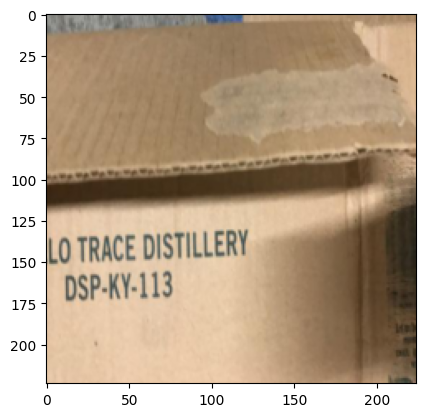

In [55]:
img, label = dataset[12]
show_sample(img, label)

Randomly allocate images to Training,Dev,Test sets

In [56]:
random_seed = 42
torch.manual_seed(random_seed)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /content/drive/MyDrive/Colab Notebooks/Datasets/CCHANGCS_Garbage ClassificationDataset.zip (Unzipped Files)/Garbage classification/Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [57]:
print(len(dataset))
total = len(dataset)
print(int(total*0.7), int(total*0.1), int(total*0.2))
# train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
train_ds, val_ds, test_ds = random_split(dataset, [1769 , 253 , 505])
len(train_ds), len(val_ds), len(test_ds)

2527
1768 252 505


(1769, 253, 505)

In [58]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [59]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [60]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

In [61]:
# show_batch(train_dl)

In [62]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [63]:
#@title MODEL SELECTION
import torchvision.models
from torchvision.models import list_models, get_model
# List available models
# print(list_models())
# print(list_models(module=torchvision.models))

# Initialize models, temporary use premade models

class AlexNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = torchvision.models.alexnet(pretrained=True)
        self.network.classifier = nn.Sequential(
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=9216, out_features=4096, bias=True),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(4096, 4096, True),
        nn.ReLU(inplace=True),
        nn.Linear(4096, len(dataset.classes), True),
        nn.LogSoftmax(dim=1)
        )

      #       (classifier): Sequential(
      # (0): Dropout(p=0.5, inplace=False)
      # (1): Linear(in_features=9216, out_features=4096, bias=True)
      # (2): ReLU(inplace=True)
      # (3): Dropout(p=0.5, inplace=False)
      # (4): Linear(in_features=4096, out_features=4096, bias=True)
      # (5): ReLU(inplace=True)
      # (6): Linear(in_features=4096, out_features=1000, bias=True)
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

class ResNet50(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

class ResNet101(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet101(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

class ResNet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

class WideResNet101(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.wide_resnet101_2(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

class MobileNet_V3L(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = torchvision.models.mobilenet_v3_large(pretrained=True)
        # # Replace last layer
        self.network.classifier = nn.Sequential(
        nn.Linear(960, 1280, bias=True),
        nn.Hardswish(),
        nn.Dropout(0.2, True),
        nn.Linear(1280, len(dataset.classes), True)
        )
      #   (classifier): Sequential(
      # (0): Linear(in_features=960, out_features=1280, bias=True)
      # (1): Hardswish()
      # (2): Dropout(p=0.2, inplace=True)
      # (3): Linear(in_features=1280, out_features=1000, bias=True)
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

class MobileNet_V3S(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = torchvision.models.mobilenet_v3_small(pretrained=True)
        # # Replace last layer
        self.network.classifier = nn.Sequential(
        nn.Linear(576, 1024, bias=True),
        nn.Hardswish(),
        nn.Dropout(0.2, True),
        nn.Linear(1024, len(dataset.classes), True)
        )
    # (classifier): Sequential(
    #   (0): Linear(in_features=576, out_features=1024, bias=True)
    #   (1): Hardswish()
    #   (2): Dropout(p=0.2, inplace=True)
    #   (3): Linear(in_features=1024, out_features=1000, bias=True)
    # )
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

class SqueezeNet_V1p1(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = torchvision.models.squeezenet1_1(pretrained=True)
        # # Replace last layer
        self.network.classifier = nn.Sequential(
        nn.Dropout(p=0.5, inplace=False),
        nn.Conv2d(512, len(dataset.classes), kernel_size=(1, 1), stride=(1, 1)),
        nn.ReLU(inplace=True),
        nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )

      #       (classifier): Sequential(
      # (0): Dropout(p=0.5, inplace=False)
      # (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
      # (2): ReLU(inplace=True)
      # (3): AdaptiveAvgPool2d(output_size=(1, 1))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

class EfficientNetV2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.efficientnet_v2_l(pretrained=True)
        # # Replace last layer
        self.network.classifier = nn.Sequential(
        nn.Dropout(0.4, True),
        nn.Linear(1280, len(dataset.classes), True)
        )
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

# LOAD MODEL HERE! Just assign the model's class, and load the saved pt file

In [64]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
# device = torch.device('cpu')
print(device)

train_dl = DeviceDataLoader(train_dl, torch.device('cpu'))
val_dl = DeviceDataLoader(val_dl, torch.device('cpu'))
test_dl = DeviceDataLoader(test_dl, torch.device('cpu'))

cuda


In [65]:
model = AlexNet()
to_device(model, device)
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/TrashModels/ResNetPT_April17_compost.pt'))
model = torch.load('/content/drive/MyDrive/Colab Notebooks/TrashModels/AlexNetNew_May9.pt')
to_device(model, torch.device('cpu'))
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (network): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (

# **ANALYZE AND JUDGE MODELS**

In [66]:
import time
# Predict image function, uses the CPU
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), torch.device('cpu'))
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]


0.039434s for the calculation
Label: glass , Predicted: glass


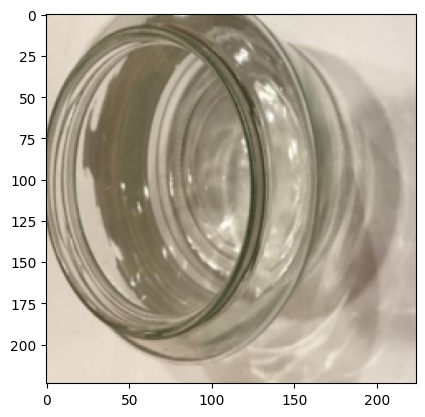

In [67]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
start = time.perf_counter()
prediction = predict_image(img, model)
end = time.perf_counter() - start
print('{:.6f}s for the calculation'.format(end))
print('Label:', dataset.classes[label], ', Predicted:', prediction)

Label: paper , Predicted: paper


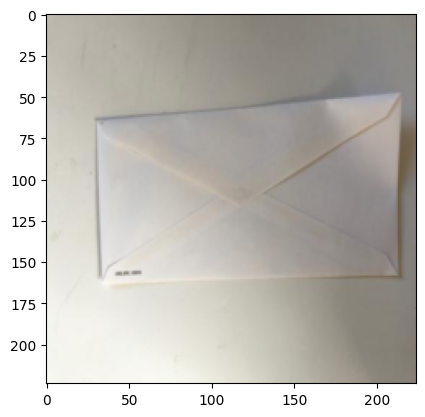

In [68]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: trash , Predicted: paper


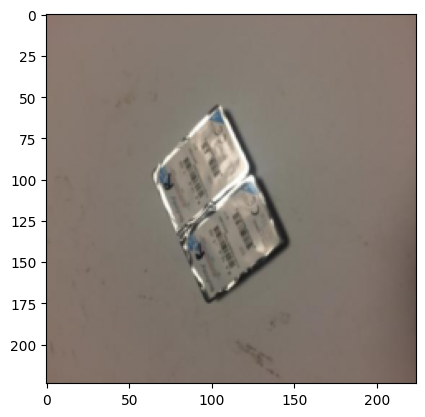

In [69]:


img, label = test_ds[80]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Confusion matrix and average latency

Top-1 Accuracy = 0.7841584158415842
0.046740s Average Latency
505 photos analyzed


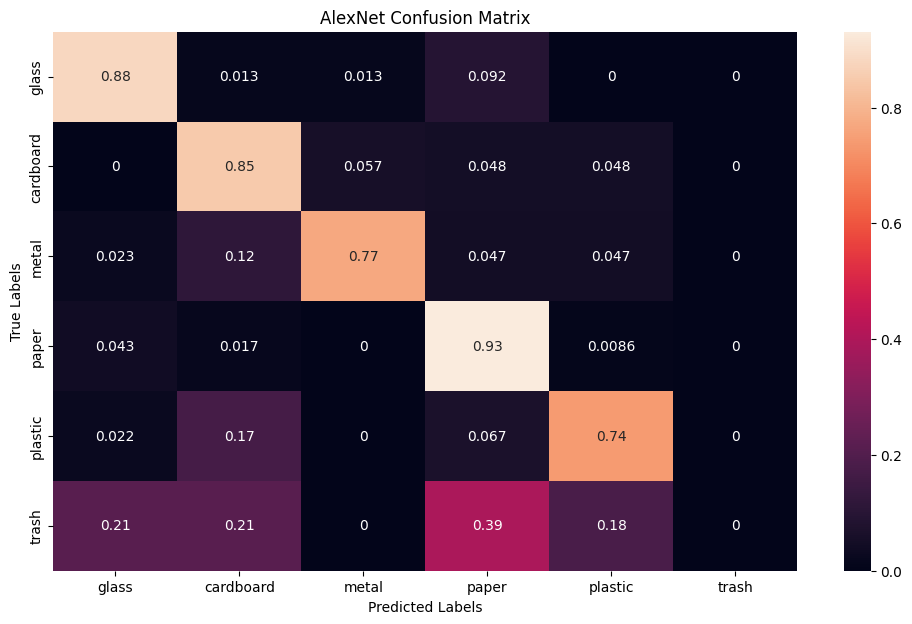

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

y_pred = []
y_true = []
totaltime = 0
correct = 0
# iterate over test data
for img, label in test_ds:
        # img, label = test_ds[x]
        # Start timer
        start = time.perf_counter()
        prediction = predict_image(img, model)
        y_pred.append(prediction) # Save Prediction
        end = time.perf_counter() - start
        totaltime += end
        truth = dataset.classes[label]
        y_true.append(truth) # Save Truth
        if(prediction == truth):
            correct += 1

# Print Stats
print(f'Top-1 Accuracy = {correct/len(test_ds)}')
print('{:.6f}s Average Latency'.format(totaltime/len(test_ds)))
print(f'{len(test_ds)} photos analyzed')
# print(y_pred)
# print(y_true)
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"{str(model.__class__.__name__)} Confusion Matrix")
plt.savefig('output.png')